# Problem Description
* 資料為3個實驗條件下的正常與異常晶圓產品，並包含19個設備感測器所提供的兩階段製程數據
* 此專案目標為在僅用正常品的數據的情況下建構數學模型，此模型將能正確反映半導體時刻設備是否異常

# Dataset introduction 

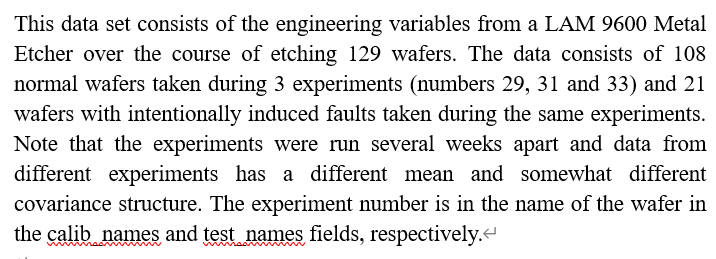 

# Step 1 : Data Visualization

In [1]:
### necessary packages ###
import os
import numpy as np 
import pandas as pd
import glob
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
warnings.filterwarnings("ignore")

In [2]:
def getFiles(dir, suffix): # 查找根目錄，副檔名 
    res = []
    filenames = []
    for root, directory, files in os.walk(dir):  # =>当前根,根下目录,目录下的文件
        for filename in files:
            name, suf = os.path.splitext(filename) # =>文件名,文件后缀(副檔名)
            if suf == suffix:
                res.append(os.path.join(root, filename)) # =>把一串字符串组合成路径
                filenames.append(name)
    return res, filenames

In [3]:
pathListTrain, filenamesTrain = getFiles(r'D:/Wade/IMStraining/Exercise 1/Dataset/Calibration', '.csv')
featuresnames = pd.read_csv(r'D:/Wade/IMStraining/Exercise 1/Dataset/variables.csv', header=None).values.flatten()
pathListTest, filenamesTest = getFiles(r'D:/Wade/IMStraining/Exercise 1/Dataset/Test', '.csv')

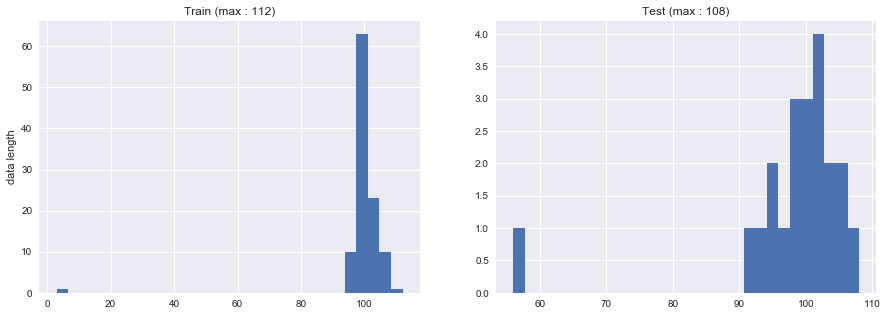

In [4]:
WaferProcessTimeTrain = []
WaferProcessTimeTest = []
#WaferIndex = []
for idx, path in enumerate(pathListTrain):
    df = pd.read_csv(path)
    WaferProcessTimeTrain.append(len(df))
for idx, path in enumerate(pathListTest):
    df = pd.read_csv(path)
    WaferProcessTimeTest.append(len(df))

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
plt.hist(np.array(WaferProcessTimeTrain), bins=30)
plt.ylabel('data length')
plt.title('Train' + ' (max : ' + str(max(WaferProcessTimeTrain)) + ')')
ax = fig.add_subplot(1, 2, 2)
plt.hist(np.array(WaferProcessTimeTest), bins=30)
plt.title('Test' + ' (max : ' + str(max(WaferProcessTimeTest)) + ')')
plt.show()

* 在正常與異常的晶圓數據中，各有一片收值異常，數據筆數過少，須予以刪除

In [5]:
for i in [(WaferProcessTimeTrain, filenamesTrain),(WaferProcessTimeTest, filenamesTest)]:
    series = pd.Series(i[0], index = i[1])
    print(series[series < 80])

l3125.txm    3
dtype: int64
l3122.txm    56
dtype: int64


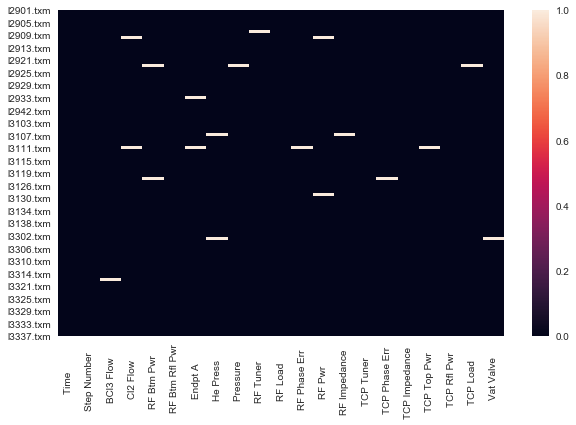

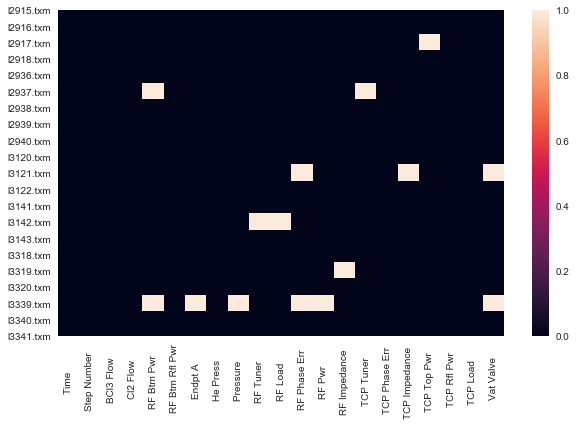

In [6]:
## cal # missing value by every feature and file
for pathlist, file in zip([pathListTrain, pathListTest], [filenamesTrain, filenamesTest]):
    res = []
    for path in pathlist:
        df = pd.read_csv(path)
        length = len(df)
        res.append(df.isnull().sum(axis=0).values)

    MissDataDF = pd.DataFrame(data = res, index=file, columns=featuresnames ) 
    fig = plt.figure(figsize=(10, 6))
    sns.heatmap(MissDataDF)

* 存在missing value

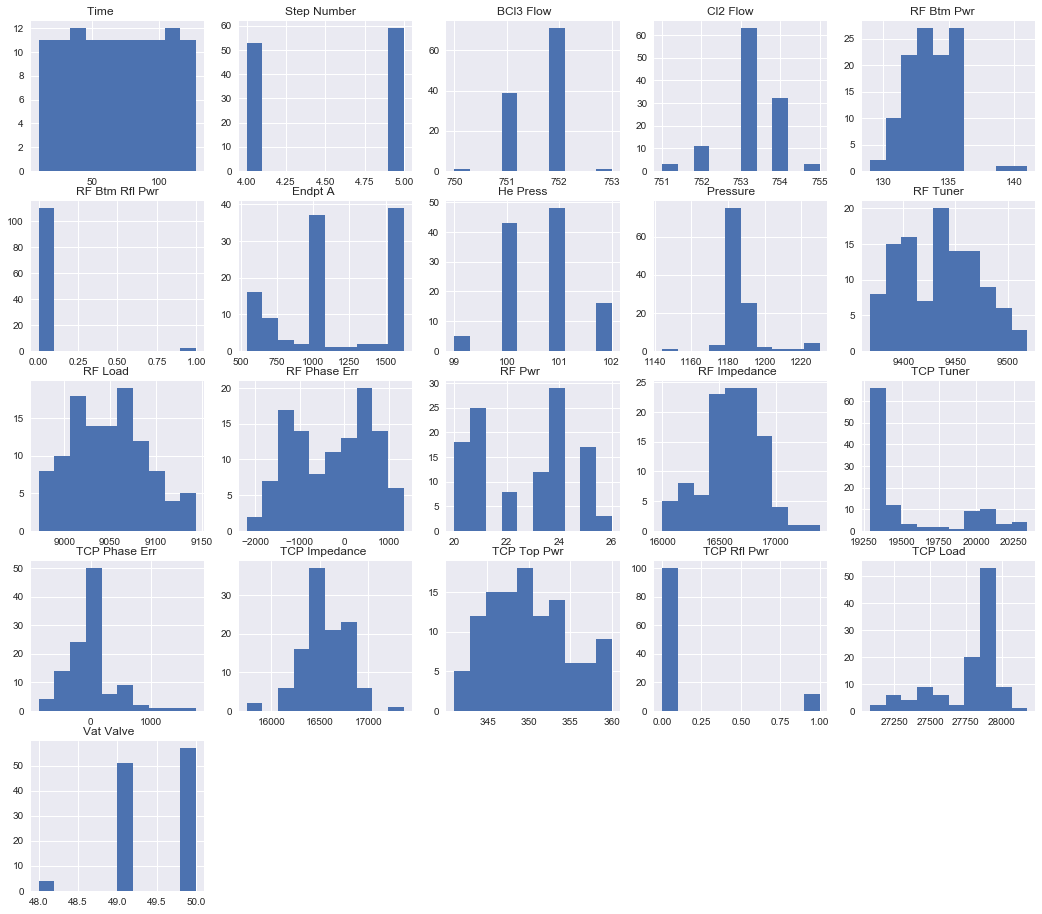

In [9]:
testdf = pd.read_csv(pathListTrain[0])

fig = plt.figure(figsize=(18, 16))
for i, col in enumerate(testdf.columns):
    plt.subplot((len(testdf.columns)//5)+1, 5, i+1)
    plt.hist(testdf.ix[:, col], bins = int(testdf.shape[0]**0.5))
    plt.title(col)
plt.show()

* 有些測項並非連續資料(感測器解析度問題)，不採用

In [10]:
#############################################################
#  use continuous features
#############################################################
usecols = testdf.apply(lambda x:len(pd.unique(x)), axis = 0)
usecols = usecols[usecols > 10].index
usecols

Index(['Time          ', 'Endpt A       ', 'Pressure      ', 'RF Tuner      ',
       'RF Load       ', 'RF Phase Err  ', 'RF Impedance  ', 'TCP Tuner     ',
       'TCP Phase Err ', 'TCP Impedance ', 'TCP Top Pwr   ', 'TCP Load      '],
      dtype='object')

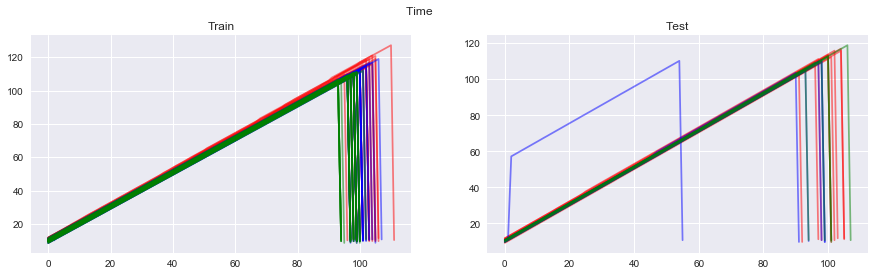

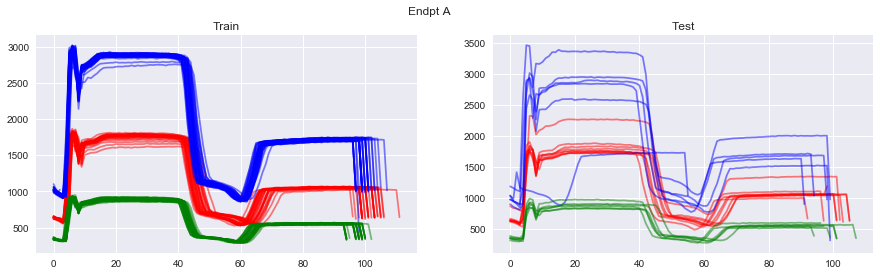

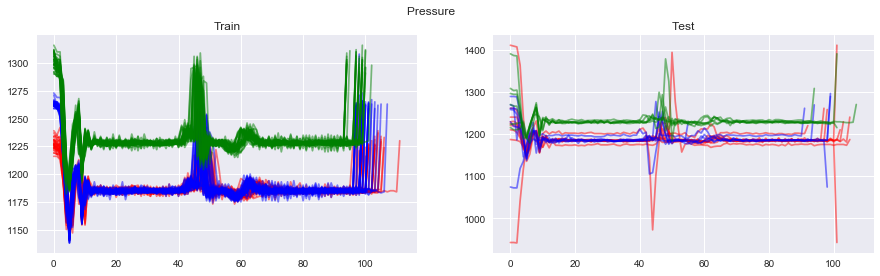

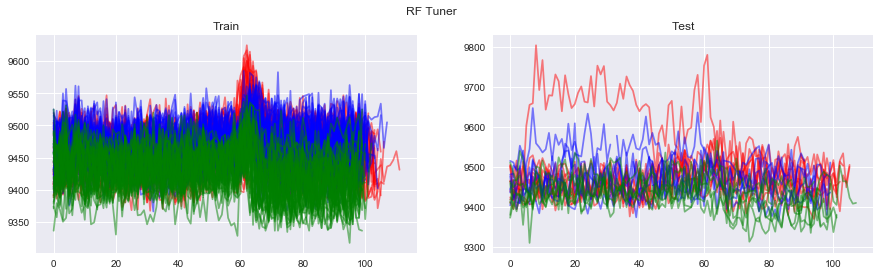

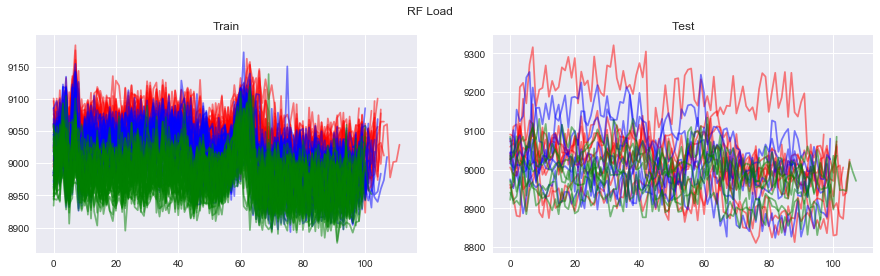

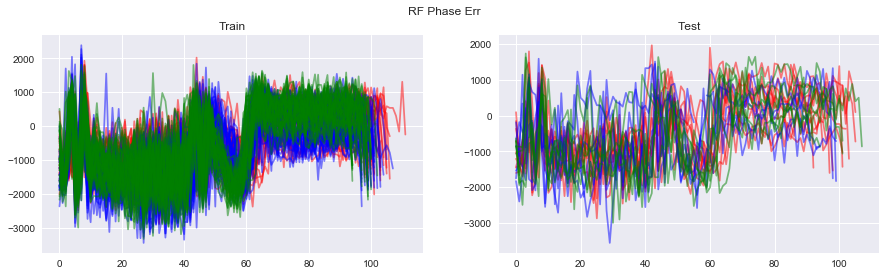

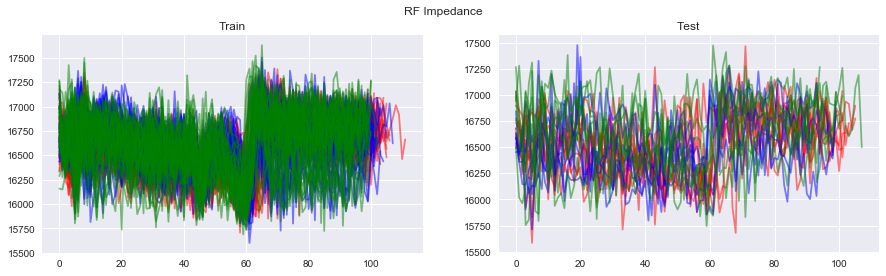

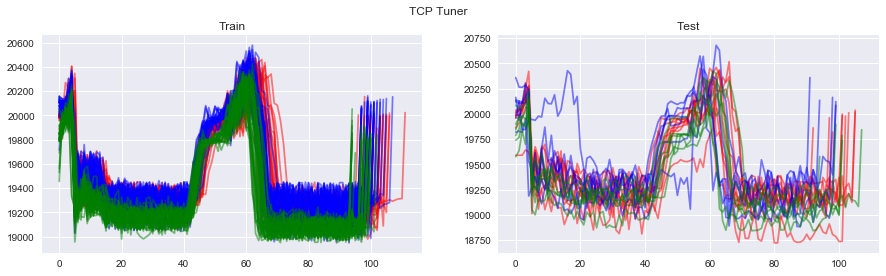

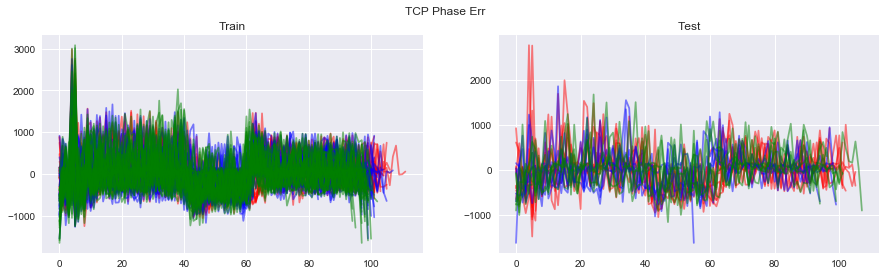

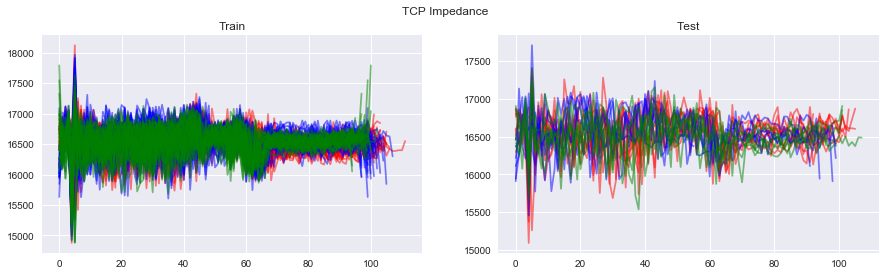

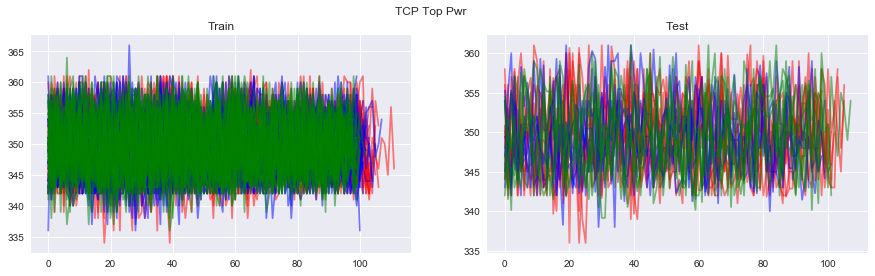

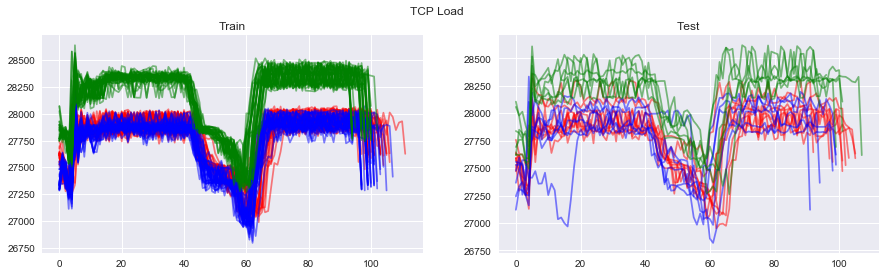

In [9]:
for col in usecols:
    fig = plt.figure(figsize=(15, 4))
    ax1 = plt.subplot(1, 2, 1)
    for i, path in enumerate(pathListTrain):
        df = pd.read_csv(path).ix[:, col]
        expid = path.split('\\')[1][:3]
        if expid == 'l29':
            ax1.plot(df, color = 'red', alpha = 0.5, label = 'l29')
        elif expid == 'l31':
            ax1.plot(df, color = 'blue', alpha = 0.5, label = 'l31')
        else :
            ax1.plot(df, color = 'green', alpha = 0.5, label = 'l33')
    ax1.set_title('Train')           
    ax = plt.subplot(1, 2, 2)
    for i, path in enumerate(pathListTest):
        df = pd.read_csv(path).ix[:, col]
        expid = path.split('\\')[1][:3]
        if expid == 'l29':
            ax.plot(df, color = 'red', alpha = 0.5, label = 'l29')
        elif expid == 'l31':
            ax.plot(df, color = 'blue', alpha = 0.5, label = 'l31')
        else :
            ax.plot(df, color = 'green', alpha = 0.5, label = 'l33')
    ax.set_title('Test')
    plt.suptitle(col)
    plt.show()

## Things need to do 
* 1.remove wafer l3122, l3125
* 2.imputate missing data

# Step2. Data Preprocessing

In [10]:
#############################################################
#  remove invalid wafer
#############################################################
pathListTrain.remove('D:/Wade/IMStraining/Exercise 1/Dataset/Calibration\\l3125.txm.csv')
filenamesTrain.remove('l3125.txm')
pathListTest.remove('D:/Wade/IMStraining/Exercise 1/Dataset/Test\\l3122.txm.csv')
filenamesTest.remove('l3122.txm')

In [11]:
#############################################################
#  imputate missing data
#############################################################

## sort time & imputate missing value by interpolate method 
def Sort_and_Imputate_Data(df):    
    new_df = df.sort_values(by = df.columns[0]).reset_index(drop=True).interpolate(method = 'nearest') ## 內插法補值
    return new_df


In [12]:
for pathlist, t in zip([pathListTrain, pathListTest], ['Train', 'Test']):
    for idx, path in enumerate(pathlist):   
        df = Sort_and_Imputate_Data(pd.read_csv(path))    ### sort and imputate
        f = path.split('\\')[1]
        ### save fil
        df.to_csv('D:/Wade/IMStraining/CleanedData/' + t +'/' + f, index = False)

In [5]:
pathListTrain, filenamesTrain = getFiles(r'D:/Wade/IMStraining/CleanedData/Train', '.csv')
featuresnames = pd.read_csv(r'D:/Wade/IMStraining/Exercise 1/Dataset/variables.csv', header=None).values.flatten()
pathListTest, filenamesTest = getFiles(r'D:/Wade/IMStraining/CleanedData/Test', '.csv')

In [22]:
pathListTrain[0].split('\\')[1].rsplit('.', 1)[0]

'l2901.txm'

## Feature Extraction
* 此專案數據屬於高頻收值，一段時間的數據只對應到該wafer OK/NG，故需提取關鍵特徵後再進行建模

In [12]:
import scipy.stats

### define time series features
def RMS(array):
    return np.sqrt((array**2).mean())

def abs_sum_of_change(array):
    return np.sum(abs(np.diff(array)))

def cid_ce(array):
    return np.sqrt(np.sum(np.diff(array)**2))

def shapeFactor(array):
    return np.sqrt((array**2).mean()) / np.mean(np.abs(array))

def crestFactor(array):
    return np.max(np.abs(array)) / np.sqrt((array**2).mean())

def impulseFactor(array):
    return np.max(np.abs(array)) / np.mean(np.abs(array))

def marginFactor(array):
    return np.max(np.abs(array)) / (np.mean(np.sqrt(np.abs(array))))**2

def mobility(array):
    return np.var(np.diff(array))/np.var(array)
    
def complexity(array):
    return (np.var(np.diff(array, n=2))/np.var(np.diff(array)))/(np.var(np.diff(array))/np.var(array))
    
def Entropy(array, base=2):
    # 计算概率分布
    probs = pd.Series(array).value_counts() / len(array)
    # 计算底数为base的熵
    en = scipy.stats.entropy(probs, base=base)
    return en

def frequencyCenter(array):
    x_p = np.diff(array)
    output = (x_p*array[1:]).sum() / (2*np.pi*np.sum(array**2))

    return output

def mean_square_frequency(array):
    x_p = np.diff(array)
    
    return np.sum(x_p**2) / 4*(np.pi**2)*np.sum(x_p**2)

def root_variance_frequency(array):
    return np.sqrt(mean_square_frequency(array) - frequencyCenter(array)**2)


def FeatExtract(array):
    res = []
    ## basic statistics (raw data)
    ## min 
    res.append(np.min(array))
    ## max 
    res.append(np.max(array))
    ## range or called P2P
    res.append(np.max(array)-np.min(array))
    ## mean
    res.append(np.mean(array))
    ## Var
    res.append(np.std(array)**2) #5
    ## RMS
    res.append(RMS(array))
    ## Q1
    res.append(np.percentile(array, 25))
    ## median
    res.append(np.percentile(array, 50))
    ## Q3
    res.append(np.percentile(array, 75))
    ## IQR
    res.append(np.percentile(array, 75)-np.percentile(array, 25)) #10
    ## skew
    res.append(scipy.stats.skew(array))
    ##kurtosis
    res.append(scipy.stats.kurtosis(array))
    ## shapeFactor
    res.append(shapeFactor(array))
    ## CresFactor
    res.append(crestFactor(array)) 
    ## impulseFactor
    res.append(impulseFactor(array)) #15
    ## Margin Factor
    res.append(marginFactor(array))
    ## mobility
    res.append(mobility(array))
    ## complexity
    res.append(complexity(array))
    ## Entropy(array, base=2)
    res.append(Entropy(array, base=2))
#     ## FC
#     res.append(frequencyCenter(array))
#     ## MSF
#     res.append(mean_square_frequency(array))
#     ## RVF
#     res.append(root_variance_frequency(array))        
    return res

In [11]:
usecols

Index(['Time          ', 'Endpt A       ', 'Pressure      ', 'RF Tuner      ',
       'RF Load       ', 'RF Phase Err  ', 'RF Impedance  ', 'TCP Tuner     ',
       'TCP Phase Err ', 'TCP Impedance ', 'TCP Top Pwr   ', 'TCP Load      '],
      dtype='object')

In [42]:
res = []
index = []
columns = []
feats = [
    'Min', 'Max', 'P2P', 'Mean', 'Var',
    'RMS', 'Q1', 'Q2', 'Q3', 'IQR',
    'Skew', 'Kurtosis','ShapeFactor', 'CresFactor', 'ImpulseFactor',
    'MarginFactor', 'Mobility', 'Complexity', 'Entropy'
]

for i, path in enumerate(pathListTrain):
    _id = path.split('\\')[1].rsplit('.', 1)[0]
    index.append(_id)
    df = pd.read_csv(path)
    value = []
    for col in usecols[1:]:
        name = col.strip(' ')

        step4 = FeatExtract(df.ix[df['Step Number   '] == 4, col])
        step5 = FeatExtract(df.ix[df['Step Number   '] == 5, col])
        value.extend(step4 + step5)
        
        if i == 0:
            columns.extend(['Step4_' + name + '_' + i for i in feats])
            columns.extend(['Step5_' + name + '_' + i for i in feats])
            
    res.append(value)
    
HealthOutput = pd.DataFrame(data = res, columns = columns, index=index)

In [43]:
HealthOutput.head(5)

,Step4_Endpt A_Min,Step4_Endpt A_Max,Step4_Endpt A_P2P,Step4_Endpt A_Mean,Step4_Endpt A_Var,Step4_Endpt A_RMS,Step4_Endpt A_Q1,Step4_Endpt A_Q2,Step4_Endpt A_Q3,Step4_Endpt A_IQR,...,Step5_TCP Load_IQR,Step5_TCP Load_Skew,Step5_TCP Load_Kurtosis,Step5_TCP Load_ShapeFactor,Step5_TCP Load_CresFactor,Step5_TCP Load_ImpulseFactor,Step5_TCP Load_MarginFactor,Step5_TCP Load_Mobility,Step5_TCP Load_Complexity,Step5_TCP Load_Entropy
l2901.txm,586.0,1627.0,1041.0,1431.094340,111384.160911,1469.494869,1503.0,1605.0,1613.0,110.0,...,386.0,-0.992528,-0.269993,1.000041,1.010561,1.010602,1.010623,0.140727,16.790794,5.551969
l2902.txm,588.0,1716.0,1128.0,1465.882353,122833.554787,1507.197607,1521.0,1644.0,1655.0,134.0,...,486.0,-0.792841,-0.895826,1.000051,1.011026,1.011077,1.011103,0.103388,21.018971,5.508161
l2903.txm,590.0,1761.0,1171.0,1508.940000,124024.456400,1549.491652,1604.5,1679.0,1683.0,78.5,...,480.5,-0.795276,-0.846985,1.000056,1.011177,1.011234,1.011262,0.113478,20.117992,5.664498
l2904.txm,591.0,1774.0,1183.0,1509.102041,138085.275302,1554.179605,1589.0,1701.0,1708.0,119.0,...,414.0,-0.975678,-0.271911,1.000047,1.009996,1.010044,1.010068,0.149831,17.332327,5.599542
l2905.txm,593.0,1788.0,1195.0,1515.980000,144804.859600,1563.009987,1609.5,1717.0,1726.0,116.5,...,430.0,-0.865649,-0.635626,1.000050,1.010479,1.010530,1.010555,0.145071,13.983604,5.549453


In [47]:
HealthOutput.to_csv('D:/Wade/IMStraining/CleanedData/HealthyOutput.csv')

In [44]:
res = []
index = []
columns = []
feats = [
    'Min', 'Max', 'P2P', 'Mean', 'Var',
    'RMS', 'Q1', 'Q2', 'Q3', 'IQR',
    'Skew', 'Kurtosis','ShapeFactor', 'CresFactor', 'ImpulseFactor',
    'MarginFactor', 'Mobility', 'Complexity', 'Entropy'
]

for i, path in enumerate(pathListTest):
    _id = path.split('\\')[1].rsplit('.', 1)[0]
    index.append(_id)
    df = pd.read_csv(path)
    value = []
    for col in usecols[1:]:
        name = col.strip(' ')

        step4 = FeatExtract(df.ix[df['Step Number   '] == 4, col])
        step5 = FeatExtract(df.ix[df['Step Number   '] == 5, col])
        value.extend(step4 + step5)
        
        if i == 0:
            columns.extend(['Step4_' + name + '_' + i for i in feats])
            columns.extend(['Step5_' + name + '_' + i for i in feats])
            
    res.append(value)
    
FaultyOutput = pd.DataFrame(data = res, columns = columns, index=index)

In [45]:
FaultyOutput.head()

,Step4_Endpt A_Min,Step4_Endpt A_Max,Step4_Endpt A_P2P,Step4_Endpt A_Mean,Step4_Endpt A_Var,Step4_Endpt A_RMS,Step4_Endpt A_Q1,Step4_Endpt A_Q2,Step4_Endpt A_Q3,Step4_Endpt A_IQR,...,Step5_TCP Load_IQR,Step5_TCP Load_Skew,Step5_TCP Load_Kurtosis,Step5_TCP Load_ShapeFactor,Step5_TCP Load_CresFactor,Step5_TCP Load_ImpulseFactor,Step5_TCP Load_MarginFactor,Step5_TCP Load_Mobility,Step5_TCP Load_Complexity,Step5_TCP Load_Entropy
l2915.txm,642.0,2323.0,1681.0,1981.040816,262417.426905,2046.201394,2089.00,2250.0,2263.00,174.00,...,397.0,-0.988814,-0.389744,1.000037,1.009455,1.009493,1.009512,0.131507,16.619002,5.532665
l2916.txm,591.0,1780.0,1189.0,1527.260000,139685.552400,1572.325876,1603.00,1719.0,1728.75,125.75,...,417.5,-0.758629,-0.606783,1.000049,1.012380,1.012430,1.012455,0.209145,12.487793,5.628783
l2917.txm,585.0,1838.0,1253.0,1582.250000,152980.979167,1629.876082,1695.00,1775.0,1785.00,90.00,...,501.5,-0.959055,-0.419411,1.000054,1.009377,1.009431,1.009459,0.176513,14.055297,5.185353
l2918.txm,531.0,1840.0,1309.0,1539.500000,158794.704545,1590.237389,1637.25,1737.5,1752.00,114.75,...,360.0,-0.650615,-0.832887,1.000044,1.011709,1.011754,1.011776,0.244169,9.522368,5.150324
l2936.txm,598.0,1903.0,1305.0,1650.739130,167533.366730,1700.727210,1754.50,1850.0,1868.00,113.50,...,497.0,-0.824812,-0.630847,1.000055,1.009470,1.009526,1.009554,0.133394,18.136296,5.392747


In [48]:
FaultyOutput.to_csv('D:/Wade/IMStraining/CleanedData/FaultyOutput.csv')

## Feature Selection 

In [3]:
Healthy_feat = pd.read_csv('D:/Wade/IMStraining/CleanedData/HealthyOutput.csv', index_col=0)
Faulty_feat = pd.read_csv('D:/Wade/IMStraining/CleanedData/FaultyOutput.csv', index_col=0)

In [89]:
wafer_name = np.r_[Healthy_feat.index.values, Faulty_feat.index.values]

In [5]:
Healthy_feat['exp'] = Healthy_feat.index.str[:3]
Faulty_feat['exp'] = Faulty_feat.index.str[:3]


In [15]:
Healthy_mean, Healthy_var = Healthy_feat.ix[:, :-1].mean(), Healthy_feat.ix[:, :-1].std()**2
Faulty_mean, Faulty_var = Faulty_feat.ix[:, :-1].mean(), Faulty_feat.ix[:, :-1].std()**2
feats = Healthy_mean.index.values

In [16]:
# fisher score (univatiate feature selection)
fisher_score = []

for f in feats:
    score = (Healthy_mean[f] - Faulty_mean[f])**2 / (Healthy_var[f] + Faulty_var[f])
    fisher_score.append(score)
    
fisher_score = pd.Series(fisher_score, index = feats).sort_values(ascending=False)

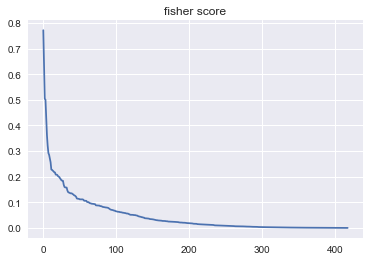

In [26]:
plt.plot(fisher_score.values)
plt.title('fisher score')
plt.show()

In [42]:
selected_features = fisher_score[:100].index.values

# Modeling (Unsupervised global model)
* 採用PCA進行建模，並以T square與SPE 統計量進行多變量管制

In [27]:
from sklearn.model_selection import train_test_split

In [48]:
X_train, X_val = train_test_split(Healthy_feat, test_size = 0.2, stratify = Healthy_feat['exp'])
X_train, X_val = X_train.ix[:, selected_features], X_val.ix[:, selected_features]
X_test = pd.concat([X_val, Faulty_feat.ix[:, selected_features]])

Y_train, Y_test = np.repeat(0, len(X_train)), np.concatenate((np.repeat(0, len(X_val)), np.repeat(1, len(Faulty_feat))), axis = 0)

In [51]:
# PCA 
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from scipy import stats
from numpy import linalg as LA

In [52]:
X_train_std = (X_train - X_train.mean()) / X_train.std()
X_test_std = (X_test - X_train.mean()) / X_train.std()

In [54]:
Globalmodel = decomposition.PCA()
Globalmodel.fit(X_train_std)
ranked_eiganvalues = pd.Series(Globalmodel.explained_variance_).sort_values(ascending = False)
ranked_eiganvector = Globalmodel.components_[ranked_eiganvalues.index.values]

In [61]:
cumulative_varience = (np.cumsum(ranked_eiganvalues) / np.sum(ranked_eiganvalues)).reset_index(drop = True)
n_component = np.where(cumulative_varience >= 0.9)[0][0]

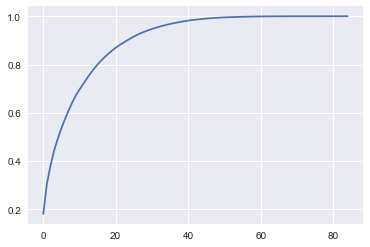

In [58]:
plt.plot(cumulative_varience)

In [71]:
def T2(projected_data, eiganvalue):
    T_2 = []
    inv_diagonal = np.linalg.inv(np.diag(eiganvalue))
    for i in range(len(projected_data)):
        T_2.append(projected_data.ix[i,:] @ inv_diagonal @ projected_data.ix[i,:].T)
        
    return T_2

In [72]:
def SPE(standarzied_data, projected_data, principle_component):
    e2 = []
    for i in range(len(standarzied_data)):
        x = standarzied_data.ix[i, :]
        u = projected_data.ix[i, :]
        e = x - u @ principle_component
        e2.append(np.sum(e**2))
        
    return e2

In [73]:
ranked_eiganvector[:n_component].shape

(24, 100)

In [74]:
PC_proj_mat = ranked_eiganvector[:n_component]
RS_proj_mat = ranked_eiganvector[n_component:]

PC_projection_train = X_train_std @ PC_proj_mat.T
PC_projection_test = X_test_std @ PC_proj_mat.T
RS_projection_train = X_train_std @ RS_proj_mat.T
RS_projection_test = X_test_std @ RS_proj_mat.T

T2_train = np.array(T2(PC_projection_train, ranked_eiganvalues[:n_component]))
T2_test = np.array(T2(PC_projection_test, ranked_eiganvalues[:n_component]))

SPE_train = np.array(SPE(X_train_std, PC_projection_train, PC_proj_mat))
SPE_test = np.array(SPE(X_test_std, PC_projection_test, PC_proj_mat))

56.08761720182949

In [76]:
def T2_Limit(data, alpha = 0.05):
    m = data.shape[0]
    r = data.shape[1]
    T2_limit = r * ((m-1)/(m-r)) * stats.f.ppf(q = 1-alpha, dfn = r, dfd = m-r)
    
    return T2_limit

T2_limit = T2_Limit(PC_projection_train)

In [79]:
def SPE_Limit(unselected_eiganvalues, alpha = 0.05):
    
    def theta(unselected_eiganvalues, degree = 1):
        return sum(unselected_eiganvalues**degree)
    
    C = stats.norm.ppf(1-alpha)
    theta1 = theta(unselected_eiganvalues, degree = 1)
    theta2 = theta(unselected_eiganvalues, degree = 2)
    theta3 = theta(unselected_eiganvalues, degree = 3)
    h0 = 1-(2*theta1*theta3)/(3*theta2**2)
    
    SPE_limit = theta1*((C*(2*theta2*(h0**2))**0.5)/theta1 + 1 + (theta2*h0*(h0-1))/(theta1**2))**(1/h0)
    
    return SPE_limit

SPE_limit = SPE_Limit(ranked_eiganvalues[n_component:])

# Vis

In [81]:
visDF = pd.DataFrame({
    'T-square':np.r_[T2_train, T2_test],
    'SPE':np.r_[SPE_train, SPE_test],
    'data_from':np.array(['train']*len(T2_train) + ['test']*len(T2_test)),
    'status' :np.r_[Y_train, Y_test]
}
)

Text(0.5, 1.0, 'T-square')

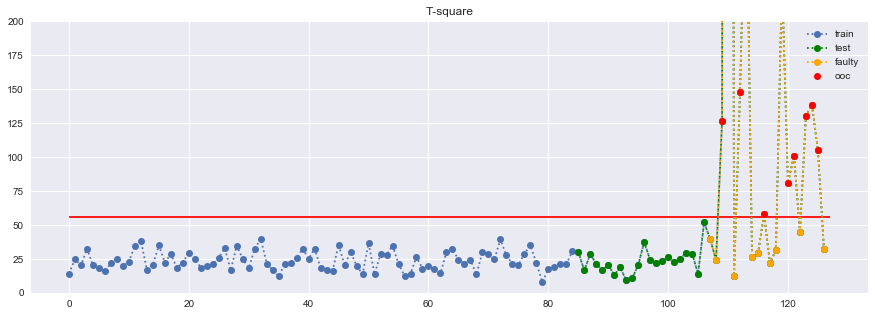

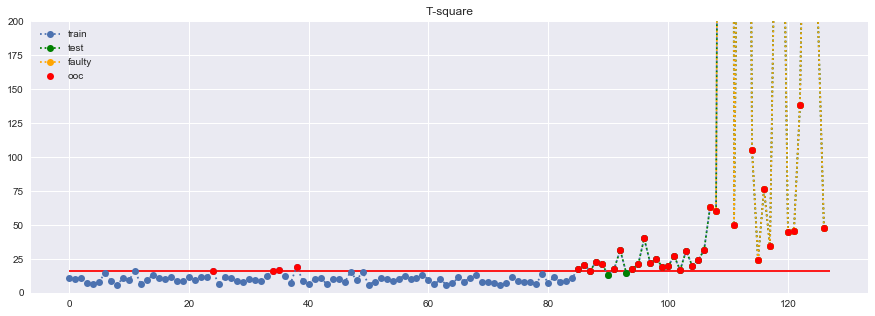

In [87]:
fig = plt.figure(figsize=(15, 5))
plt.plot(visDF['T-square'].index, visDF['T-square'], marker='o', ls=':', label='train')
plt.plot(visDF.ix[visDF['data_from'] == 'test', 'T-square'].index, visDF.ix[visDF['data_from'] == 'test', 'T-square'], marker='o', ls=':', color = 'green', label = 'test')
plt.plot(visDF.ix[visDF['status'] == 1, 'T-square'].index, visDF.ix[visDF['status'] == 1, 'T-square'], marker='o', ls=':', color = 'orange', label='faulty')
plt.plot(visDF.ix[visDF['T-square'] > T2_limit, 'T-square'].index, visDF.ix[visDF['T-square'] > T2_limit, 'T-square'], 'ro', label = 'ooc')
plt.legend()
plt.hlines(T2_limit, 0, len(visDF), color = 'red')
plt.ylim((0,200))
plt.title('T-square')

fig = plt.figure(figsize=(15, 5))
plt.plot(visDF['SPE'].index, visDF['SPE'], marker='o', ls=':', label='train')
plt.plot(visDF.ix[visDF['data_from'] == 'test', 'SPE'].index, visDF.ix[visDF['data_from'] == 'test', 'SPE'], marker='o', ls=':', color = 'green', label = 'test')
plt.plot(visDF.ix[visDF['status'] == 1, 'SPE'].index, visDF.ix[visDF['status'] == 1, 'SPE'], marker='o', ls=':', color = 'orange', label='faulty')
plt.plot(visDF.ix[visDF['SPE'] > SPE_limit, 'SPE'].index, visDF.ix[visDF['SPE'] > SPE_limit, 'SPE'], 'ro', label = 'ooc')
plt.legend()
plt.hlines(SPE_limit, 0, len(visDF), color = 'red')
plt.ylim((0,200))
plt.title('T-square')

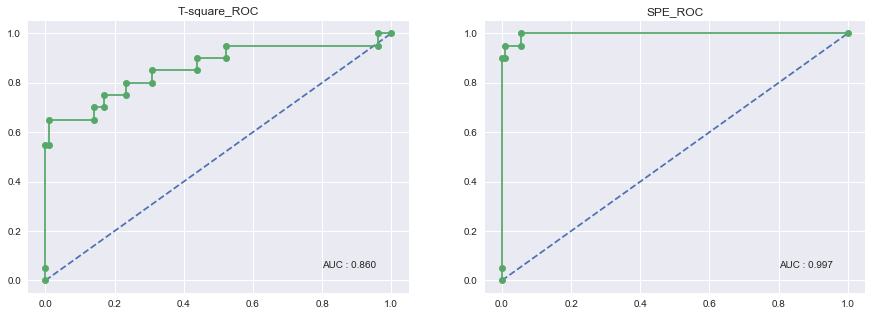

In [93]:
from sklearn import metrics
fig = plt.figure(figsize=(15,5))
for i, m in enumerate(['T-square', 'SPE']):
    ax = fig.add_subplot(1,2,i+1)
    fpr, tpr, _ = metrics.roc_curve(visDF['status'], visDF[m], pos_label=1)
    auc = metrics.roc_auc_score(visDF['status'], visDF[m])
    plt.title(m+'_ROC')
    plt.text(0.8,0.05, 'AUC : %.3f'%auc)
    plt.plot([0,1],[0,1], ls = '--')
    plt.plot(fpr, tpr, marker = 'o')
plt.show()